<a href="https://colab.research.google.com/github/ngupta23/ds7337_nlp/blob/master/Exams/finals/NGupta_question2_LSTM_twitter_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
from typing import List, Tuple
from time import time
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_hub as hub

In [3]:
tf.__version__

'2.3.0'

# Get Data

In [4]:
!rm -rf ./*

In [5]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2020-08-08 03:33:49--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  37.1MB/s    in 2.1s    

2020-08-08 03:33:51 (37.1 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [6]:
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data = data[[5, 0]]
data.head()

,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [10]:
data = data.rename(columns={5:'text', 0:'sentiment'})
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Prepare Labels

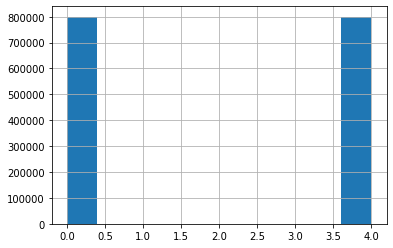

In [11]:
data['sentiment'].hist()

In [12]:
data['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [13]:
data.loc[data['sentiment'] == 4, 'sentiment'] = 1

In [14]:
data['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [15]:
data.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


# Shuffle Data

In [16]:
data = data.sample(frac=1).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   sentiment  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Max Sequence Length

The number of characters reaches a max length of 374, but that might be an exception. For Universal Sentence Encoder (USE), we can possibly limit this to a smaller number based on the histogram of character lengths. 

The number of words reaches a maximum value of 64. For RNN variants, again, we can limit this to a smaller number based on the distribution of the number of words as shown below

In [17]:
data['charlen'] = data['text'].str.len()
data['wordlen'] = data['text'].str.split().str.len()
data.head()

,text,sentiment,charlen,wordlen
0,shop shop shopping with adub,1,29,5
1,@sparkly72 I tried to save yur comment earlier...,0,105,20
2,@_JadeLakeasha no. no i didnt people kept get...,0,83,15
3,twitter= novo viciu {2},0,24,4
4,No!!! All my afternoon pts are showing up. af...,0,94,18


In [18]:
print('Maximum review length (words): {}'.format(data['wordlen'].max()))
print('Minimum review length (words): {}'.format(data['wordlen'].min()))
print('Maximum review length (chars): {}'.format(data['charlen'].max()))
print('Minimum review length (chars): {}'.format(data['charlen'].min()))


Maximum review length (words): 64
Minimum review length (words): 1
Maximum review length (chars): 374
Minimum review length (chars): 6


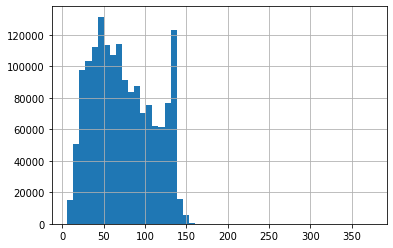

In [19]:
data['charlen'].hist(bins=50)

In [20]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_USE = int(np.quantile(data['charlen'],0.975))
time_steps_USE

138

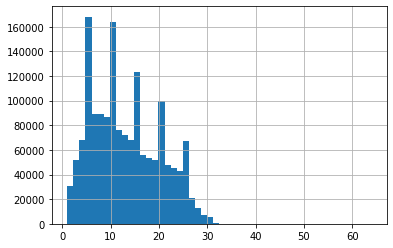

In [21]:
data['wordlen'].hist(bins=50)

In [22]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.
time_steps_RNN = int(np.quantile(data['wordlen'],0.975))
time_steps_RNN

27

# Train and Validation Split

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    data['text'].values.astype('U'),
    data['sentiment'].values.astype('int32'),
    test_size=0.5,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_val)}, y_test: {len(y_val)}")

Number of samples: X_train: 800000, y_train: 800000
Number of samples: X_test: 800000, y_test: 800000


In [27]:
# Checking split --> both test and train contain roughly the same % of observation from each class
print(sum(y_train == 0)/len(y_train), sum(y_val == 0)/len(y_val))
print(sum(y_train == 1)/len(y_train), sum(y_val == 1)/len(y_val))

0.50026125 0.49973875
0.49973875 0.50026125


# Vocabulary

In [60]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
X_train[0:3]

array(['I have been pushing it way too hard.  Feeling like junk and just needs a cuddle buddy ',
       '@pickerbrad Thank you ',
       '@Omargunz yeah im up right now @ work.... and im still sleepy... '],
      dtype='<U374')

In [61]:
tweet_tokenizer = TweetTokenizer()

In [66]:
start = time()
X_train_list = list(map(tweet_tokenizer.tokenize, X_train)) 
end = time()
print(f"Time taken: {end-start}s")

Time taken: 31.99128770828247s


In [67]:
corpus = [word for line in X_train_list for word in line]

In [68]:
print(corpus[:30])

['I', 'have', 'been', 'pushing', 'it', 'way', 'too', 'hard', '.', 'Feeling', 'like', 'junk', 'and', 'just', 'needs', 'a', 'cuddle', 'buddy', '@pickerbrad', 'Thank', 'you', '@Omargunz', 'yeah', 'im', 'up', 'right', 'now', '@', 'work', '...']


In [69]:
# Get only words that have occured more than once to remove noise, spelling mistakes and possible tokenization errors.
fdist = nltk.FreqDist(corpus)
print(fdist.most_common()[:20])
vocab = [word for word, count in fdist.most_common() if count >= 1]
print(vocab[:20])

[('!', 428603), ('.', 412143), ('to', 279071), ('I', 256583), ('the', 245127), (',', 242214), ('a', 184259), ('my', 141909), ('and', 141012), ('...', 137678), ('i', 129482), ('you', 123954), ('?', 116465), ('is', 111723), ('it', 107040), ('for', 106338), ('in', 103342), ('of', 90354), ('on', 79994), ('me', 77621)]
['!', '.', 'to', 'I', 'the', ',', 'a', 'my', 'and', '...', 'i', 'you', '?', 'is', 'it', 'for', 'in', 'of', 'on', 'me']


In [70]:
len(vocab)

530406

# Encoding and Decoding Dictionary

In [71]:
word_index = {}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
for index, word in enumerate(vocab):
  word_index[word] = index+3

In [72]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
[(i, reverse_word_index.get(i)) for i in np.arange(10)]

[(0, '<PAD>'),
 (1, '<START>'),
 (2, '<UNK>'),
 (3, '!'),
 (4, '.'),
 (5, 'to'),
 (6, 'I'),
 (7, 'the'),
 (8, ','),
 (9, 'a')]

In [73]:
vocabulary_size = len(word_index.keys())
vocabulary_size

530409

In [74]:
def encode_data(plain_text: str) -> List[int]:
  return [word_index[token] if token in word_index.keys() else word_index["<UNK>"] for token in tweet_tokenizer.tokenize(plain_text)]

def decode_data(encoded_text):
  return ' '.join([reverse_word_index.get(i, '?') for i in encoded_text])

In [86]:
def encode_decode_check(original_data):
  print("\n")
  print(f"Original Data: {original_data}")
  encoded_data = encode_data(original_data)
  print(f"Encoded Data: {encoded_data}")
  decoded_data = decode_data(encoded_data)
  print(f"Decoded Data: {decoded_data}")
  # print(type(decoded_data))
  # print(type(str(original_data)))
  same = str(decoded_data) == str(original_data)
  # print(f"Decoded = Original: {same}")

In [91]:
random_train = X_train[np.random.choice(len(X_train), 5)]
random_train

for single_data in random_train:
  encode_decode_check(single_data)



Original Data: 3 day weekend 
Encoded Data: [180, 40, 173]
Decoded Data: 3 day weekend
<class 'str'>
<class 'str'>
Decoded = Original: False


Original Data: ahh im marved. smh. . time to force myself to sleep then  . Night twitter ville
Encoded Data: [1148, 83, 284558, 4, 2683, 2128, 58, 5, 3494, 315, 5, 124, 107, 4, 838, 147, 21319]
Decoded Data: ahh im marved . smh . . time to force myself to sleep then . Night twitter ville
<class 'str'>
<class 'str'>
Decoded = Original: False


Original Data: so i changed my twitter BG but its still the zebra stripes?? is that what yall see too  not good
Encoded Data: [25, 13, 1220, 10, 147, 10941, 26, 92, 90, 7, 14965, 15737, 15, 15, 16, 24, 75, 1605, 72, 51, 34, 45]
Decoded Data: so i changed my twitter BG but its still the zebra stripes ? ? is that what yall see too not good
<class 'str'>
<class 'str'>
Decoded = Original: False


Original Data: I'm sad Jon &amp; Kate are calling it quits 
Encoded Data: [30, 123, 1902, 61, 2022, 44, 1449, 17, 

In [83]:
random_val = X_val[np.random.choice(len(X_val), 5)]
random_val

for single_data in random_val:
  encode_decode_check(single_data)



Original Data: Can't find cheap tickets for Saturday! Want to see Big Weaver vs Little Weaver  #angels #dodgers
Encoded Data: [379, 213, 2025, 801, 18, 730, 3, 1927, 5, 72, 1253, 58595, 1804, 2393, 58595, 349006, 390781]
Decoded Data: Can't find cheap tickets for Saturday ! Want to see Big Weaver vs Little Weaver #angels #dodgers
Decoded = Original: False


Original Data: I have a cold 
Encoded Data: [6, 23, 9, 349]
Decoded Data: I have a cold
Decoded = Original: False


Original Data: Apparently I still like boys... Sorry @melbot 
Encoded Data: [2221, 6, 90, 42, 796, 12, 414, 2]
Decoded Data: Apparently I still like boys ... Sorry <UNK>
Decoded = Original: False


Original Data: @stephietan No point because you'll sweat right out of the shower 
Encoded Data: [54434, 187, 923, 233, 756, 4348, 125, 39, 20, 7, 695]
Decoded Data: @stephietan No point because you'll sweat right out of the shower
Decoded = Original: False


Original Data: @April_Slaughter nope, nope, not a philly roll! A 

In [97]:
start = time()
X_train_encoded = [encode_data(line) for line in X_train]
end = time()
print(f"Time taken: {end-start}s")

Time taken: 36.56882166862488s


In [98]:
start = time()
X_val_encoded = [encode_data(line) for line in X_val]
end = time()
print(f"Time taken: {end-start}s")

Time taken: 36.78495526313782s


In [99]:
from tensorflow.keras.preprocessing import sequence

X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps_RNN)
X_val_encoded = sequence.pad_sequences(X_val_encoded, maxlen=time_steps_RNN)

In [100]:
X_train_encoded[0:5]

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      6,     23,    108,   5144,     17,    138,     51,
           325,      4,   1012,     42,   3841,     11,     33,    581,
             9,   2673,   1607],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
        160793,    366,     14],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,  58535,    199,     83,
            36,    125,     38,    248,     50,     12,     11,     83,
            90,    889,     12],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,    694,   2825,   3333,    286,
            12,    204,    123],
    

In [101]:
X_val_encoded[0:5]

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,  10487,      2,     80,   1219,
             8,    103,    343,      2,     48,     76,     23,     19,
            98,     15,      2],
       [     0, 319893,   6568,     18,  47562,    627,    461,    112,
          1549,    283,     37,  10464,      4,    653,     28,  50945,
            64,     75,      5,    944,     19,     64,     99,    391,
             4,    465,      3],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,     13,     57,     10,     91,    447,     12,     33,
           102,    672,    112,   2313,     12,     46,      2,     21,
             7,   4743,      3],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,   3215,     16,   1334,    140,   2687,    106,    208,
            40,     29,     50,     18,     22,    104,      6,     85,
           150,      3,      3],
    

# Training

In [102]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM as LSTM
from tensorflow.keras.layers import GRU as GRU

In [103]:
def plot_metrics(history: tf.python.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [104]:
def create_model(
    vocabulary_size: int,
    time_steps: int,
    embedding_size: int,
    num_classes: int,
    type: str = 'lstm',
    num_neuron: int=100,
    dropout: float=0,
    recurrent_dropout: float=0
    ) -> tf.keras.layers.Layer:
  """
  Creates a Sequence Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param type Type of sequence model (Options: 'simple_rnn', 'lstm' or 'gru' (Default: 'lstm')
  :type type str
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = Sequential()
  model.add(Embedding(vocabulary_size, embedding_size, input_length=time_steps))
  if type.lower() == 'simple_rnn':
    model.add(RNN(num_neuron, recurrent_dropout=recurrent_dropout))
  elif type.lower() == 'lstm':
    model.add(LSTM(num_neuron, recurrent_dropout=recurrent_dropout))
  elif type.lower() == 'gru':
    model.add(GRU(num_neuron, recurrent_dropout=recurrent_dropout))
  else:
    sys.exit("You have not passed the right argument for type.")
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_simple_rnn_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Simple RNN Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'simple_rnn', num_neuron, dropout, recurrent_dropout)
  return model

def create_lstm_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a LSTM Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'lstm', num_neuron, dropout, recurrent_dropout)
  return model

def create_gru_model(vocabulary_size: int, time_steps: int, embedding_size: int, num_classes: int, num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a GRU Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_classes Number of Classes to predict (2 for binary, 3 for ternary, etc.)
  :type num_classes int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model(vocabulary_size, time_steps, embedding_size, num_classes, 'gru', num_neuron, dropout, recurrent_dropout)
  return model

In [105]:
num_classes = len(set(y_train))
num_classes

2

In [106]:
from tensorflow.keras.callbacks import EarlyStopping
# If validation error does not improve for 'patience' epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=3)

In [107]:
# import other libs as needed for building model
from tensorflow.keras.callbacks import ModelCheckpoint

# add a checkpoint to save the lowest validation loss
filepath = '.'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 27, 50)            26520450  
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 26,540,752
Trainable params: 26,540,752
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7563
Epoch 00001: val_loss improved from inf to 0.42758, saving model to .
INFO:tensorflow:Assets written to: ./assets
196/196 [================

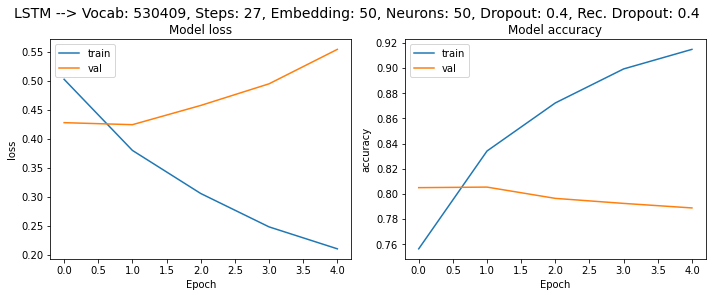

In [108]:
vocabulary_size = vocabulary_size
embedding_size = 50 # 100
time_steps = time_steps_RNN
num_neuron = 50 # 100
dropout = 0.4
recurrent_dropout = 0.4
EPOCHS = 10
BATCH_SIZE = 4096 #  1024

# Build Model and Train
model = create_lstm_model(
    vocabulary_size=vocabulary_size,
    embedding_size=embedding_size,
    time_steps=time_steps,
    num_classes=num_classes,
    num_neuron=num_neuron,
    dropout=dropout,
    recurrent_dropout=recurrent_dropout
  )
print(model.summary())

history = model.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, checkpoint]
  )

plot_metrics(history,
             metrics=['loss', 'accuracy'],
             title = f"LSTM --> Vocab: {vocabulary_size}, Steps: {time_steps}, Embedding: {embedding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")